In [4]:
from qiskit_ibm_runtime import Session
from qiskit.providers.aer import AerSimulator
from qiskit.algorithms.minimum_eigen_solvers import QAOA
from qiskit.circuit.library import QAOAAnsatz
from qiskit.algorithms.optimizers import COBYLA
from qiskit_ibm_runtime import QiskitRuntimeService
import networkx as nx
from qiskit_optimization.translators import to_ising
from qiskit_optimization.applications import Maxcut

In [ ]:
service = QiskitRuntimeService()
method = "statevector"
device = "CPU"
backend = AerSimulator(method=method, device=device)

## 1) Input CNF
A 3SAT CNF is of the form $(x_1 \lor x_2 \lor x_3) \land (\neg x_2 \lor x_3 \lor x_4)$ for example

In this notebook, we will assume that the cnf variables ($x_1, x_2, ...$) are given as integers (starting from 0) instead of strings, i.e.
$x_1 \mapsto 0$, $x_2 \mapsto 1$, etc... This is not very intuitive but it makes parsing easier. We might change it later.

- $\neg$ operator: The negation is denoted by an `n` in front of a particular variable $\implies$ Ex: $\neg x_2 \mapsto$ `n3`
- $\lor$ operator: The $\lor$ operator is denoted by a space between operands $\implies$ Ex: $x_1 \lor \neg x_2 \lor x_3 \mapsto$ `0 n1 2` 
- $\land$ operator: The $\land$ operator is denoted by a comma (`,`) between clauses $\implies$ Ex: $(x_1 \lor \neg x_2 \lor x_3) \land (\neg x_1 \lor \neg x_2 \lor \neg x_3) \mapsto$ `0 n1 2,n0 n1 n2`

Therefore, for example, given the following CNF:

$(x_1 \lor x_2 \lor \neg x_3) \land (x_3 \lor \neg x_1 \lor \neg x_6) \land (\neg x_2 \lor x_4 \lor x_5) \land (\neg x_4 \lor \neg x_5 \lor x_6)$

the input CNF to this program will be formulated as

`0 1 n2,2 n0 n5,n1 3 4,n3 n4 5` (as a string)


### Parsing the Input CNF
Given an input CNF, we want to parse is so that
- Instead of having variables `0`, `1`, `2`..., `n0`, `n1`, `n2`, ... we will work with only integers from now on, therefore we will transform the input CNF into a list of integers such that `x` $\mapsto$ `x`, and `nx` $\mapsto$ `x+N` (where `N` is the number of variables)
- Ex: `0 1 n2,2 n0 n5,n1 3 4,n3 n4 5` will be parsed to `parsed_cnf = [0,1,8,2,6,11,7,3,4,9,10,5]`
- We don't need commas or spaces anymore since we know that the input is a 3SAT CNF, so we know the first clause is represented by `(0,1,8)`, the second one by `(2,6,11)`, etc.

The function `parse_cnf()` will ask for two inputs from the user:
- The number of variables (here we count $x$ and $\neg x$ as one variable), so the CNF above has `6` variables.
- The CNF (ex: `0 1 n2,2 n0 n5,n1 3 4,n3 n4 5`)

In [5]:
def parse_cnf():
    """Asks the user to input the number of variables used and the CNF itself, and parses the CNF

    Returns
    -------
    list(int)
        the parsed CNF according to the conventions we decide to use
    """
    num_variables = int(input("Enter the number of variables: "))
    cnf = input("Enter the CNF of the form above (ex: 0 1 2,0 n1 2): ")
    clauses = cnf.replace(",", " ")
    parsed_cnf = clauses.split(" ")
    for i in range(len(parsed_cnf)):
        if parsed_cnf[i].startswith("n"):
            parsed_cnf[i] = str(int(parsed_cnf[i][1:])+num_variables)
    parsed_cnf = list(map(lambda elem: int(elem), parsed_cnf))
    return parsed_cnf, num_variables

In [17]:
# Example: 
# - Number of variables: 6
# - CNF: 0 1 n2,2 n0 n5,n1 3 4,n3 n4 5
parsed_cnf, num_variables = parse_cnf()
print(f"Parsed CNF: {parsed_cnf}")

Parsed CNF: [0, 1, 8, 2, 6, 11, 7, 3, 4, 9, 10, 5]


In [21]:
M = 30 # Penalty Factor
num_negated_variables = 0
for i in range(num_variables):
    if i in parsed_cnf and i+num_variables in parsed_cnf:
        num_negated_variables += 1
theoretical_gse = -len(parsed_cnf)/3 -M*num_negated_variables

## 2) Create a graph from the CNF
Let us transform the CNF into a graph $G$, where
- Each clause maps to a triangle
- The weight of an edge $(i,j)$, $W_{ij}$, is set to $M$ if $j = i+N$, otherwise it is set to the number of triangles that share the edge $(i,j)$.

In [6]:
# Create a graph G from an already-parsed CNF
def create_graph_from_cnf(parsed_cnf, num_variables, penalty_factor):
    """Creates a weighted graph from a CNF

    Parameters
    ----------
    parsed_cnf : list(int)
        the parsed cnf containing values in [0, 2N-1]
    num_variables : int
        the number of variables used in the CNF (= N)
    penalty_factor: int
        the penalty factor used for assuring consistency

    Returns
    -------
    nx.Graph
        the obtained graph
    """
    
    # All the variables used in the parsed cnf (ranging from 0 to 2N-1)
    cnf_variables = set(parsed_cnf)

    # All the variables used in the original CNF (ranging from 0 to N-1)
    variables = set(range(num_variables))

    # Will contain the weight associated with each edge (i,j)
    edge_weights = {}

    G = nx.Graph()

    # Create the vertices
    vertices = list(cnf_variables)
    G.add_nodes_from(vertices)
    # Iterate over the parsed CNF per clause (3 elements by 3 elements)
    for i in range(0, len(parsed_cnf), 3):

        # First edge
        # If that edge already exists in the map, add 1 to its value
        if (parsed_cnf[i], parsed_cnf[i+1]) in edge_weights:
            edge_weights[(parsed_cnf[i], parsed_cnf[i+1])] = edge_weights[(parsed_cnf[i], parsed_cnf[i+1])] + 1
        else: # Otherwise, set the weight value to 1
            edge_weights[(parsed_cnf[i], parsed_cnf[i+1])] = 1

        # Second edge
        # If that edge already exists in the map, add 1 to its value
        if (parsed_cnf[i], parsed_cnf[i+2]) in edge_weights:
            edge_weights[(parsed_cnf[i], parsed_cnf[i+2])] = edge_weights[(parsed_cnf[i], parsed_cnf[i+2])] + 1
        else: # Otherwise, set the weight value to 1
            edge_weights[(parsed_cnf[i], parsed_cnf[i+2])] = 1

        # Third edge
        # If that edge already exists in the map, add 1 to its value
        if (parsed_cnf[i+1], parsed_cnf[i+2]) in edge_weights:
            edge_weights[(parsed_cnf[i+1], parsed_cnf[i+2])] = edge_weights[(parsed_cnf[i+1], parsed_cnf[i+2])] + 1
        else: # Otherwise, set the weight value to 1
            edge_weights[(parsed_cnf[i+1], parsed_cnf[i+2])] = 1
    
    # Add all the "clause edges" to the graph after calculating all the weights needed
    for (u,v) in edge_weights.keys():
        G.add_edge(u, v, weight=edge_weights[(u,v)], color="b")


    # Add all the "constraint" edges to the graph, with a weight of penalty_factor each
    for var in variables:
        # Check if both x and not(x) exist in the CNF (otherwise we don't need to add the penalty term)
        if var in cnf_variables and var + num_variables in cnf_variables:
            G.add_edge(var, var+num_variables, weight=penalty_factor, color="r")    
    
    return G

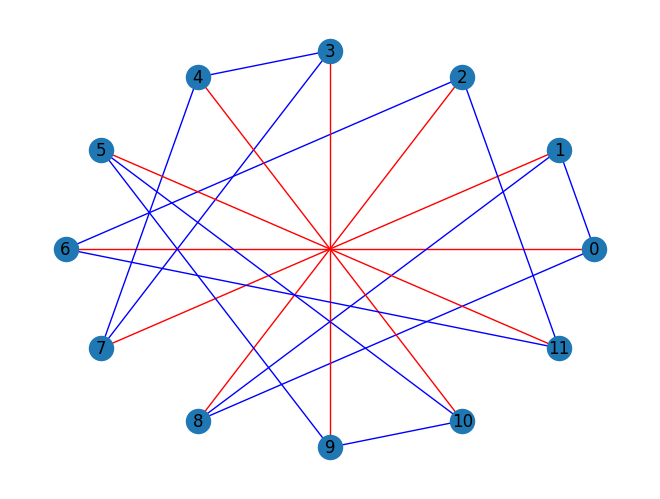

In [23]:
G = create_graph_from_cnf(parsed_cnf, num_variables, M)
nx.draw_circular(G, with_labels=True, edge_color=[G[u][v]['color'] for u,v in G.edges])

## 3) Create a quadratic program for the MaxCut Problem
Using the `Maxcut` class from the `qiskit_optimization.applications` package, we can create the Max-Cut quadratic program from our graph G.


In [7]:
def create_quadratic_program(G):
    """ Creates a quadratic program from a graph G

    Parameters
    ----------
    G: nx.Graph
        the input graph
    
    Returns
    -------
    QuadraticProgram
        the resulting quadratic program formulation
    """
    maxcut = Maxcut(G)
    return maxcut.to_quadratic_program()

## 4) Convert to Hamiltonian
We can now convert the model to a `QuadraticProgram` to a Hamiltonian using `to_ising(QP_instance)`

In [ ]:
nae3sat_qp = create_quadratic_program(G)
hamiltonian, offset = to_ising(nae3sat_qp)
print(hamiltonian)

In [8]:
# Cell copied from https://qiskit.org/documentation/tutorials/algorithms/05_qaoa.html
from collections import OrderedDict
from qiskit.opflow import StateFn
import numpy as np


def sample_most_likely(state_vector):
    """Compute the most likely binary string from state vector.
    Args:
        state_vector (numpy.ndarray or dict): state vector or counts.
    Returns:
        numpy.ndarray: binary string as numpy.ndarray of ints.
    """
    if isinstance(state_vector, (OrderedDict, dict)):
        # get the binary string with the largest count
        binary_string = sorted(state_vector.items(), key=lambda kv: kv[1])[-1][0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    elif isinstance(state_vector, StateFn):
        binary_string = list(state_vector.sample().keys())[0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    else:
        n = int(np.log2(state_vector.shape[0]))
        k = np.argmax(np.abs(state_vector))
        x = np.zeros(n)
        for i in range(n):
            x[i] = k % 2
            k >>= 1
        return x

## 4) Error Calculation
To calculate the error, we will look at the results (`eigenstate`) which are the values (0 or 1) we assign to the variables, and check two things:
- NAE-SAT errors: If a clause is not NAE-SAT, then we add 1 to the NAE-SAT error
- Consistency errors: If a variable is the same as its negation, we add 1 to the consistency error

Error calculation will be done after running QAOA

In [9]:
def calculate_error(parsed_cnf, num_variables, result):
    """Calculate the NAE-3SAT error

    Parameters
    ----------
    parsed_cnf: list(int)
        the initial parsed CNF
    num_variables: int
        the number of variables used (without distinguishing x and not x)
    result: list(int)
        the resulting variable assignments

    Returns
    int, int
        the NAE-SAT error and the consistency error, respectively
    """
    
    nae_sat_error = 0
    consistency_error = 0
    # Iterate over the clauses of the CNF
    for i in range(0, len(parsed_cnf), 3):
        v1 = result[parsed_cnf[i]]
        v2 = result[parsed_cnf[i+1]]
        v3 = result[parsed_cnf[i+2]]
        # if clause is satisfied but not SAT-NAE, or if the clause is not satisfied, we add 1 to nae_sat_error
        if v1 + v2 + v3 == 3 or v1 + v2 + v3 == 0:
            nae_sat_error += 1
    
    for i in range(num_variables):
        # if a variable is the same as its negation, we add 1 to consistency_error
        if  i + num_variables < len(result) and result[i] == result[i+num_variables]:
            consistency_error += 1
    return nae_sat_error, consistency_error

## 5) Solve on a Quantum Computer using QAOA
We can now input this Hamiltonian to QAOA to compute its ground state energy and the corresponding eigenstate (that will contain the solution to our problem)

In [ ]:
# QAOA Settings
ansatz = QAOAAnsatz(hamiltonian)
session = Session(backend=backend)
service = QiskitRuntimeService()

# Test Settings
num_successes = 0
num_runs = 20

# The QAOA
qaoa = QAOA(optimizer=COBYLA(maxiter=1000), quantum_instance=backend, reps=1)

output = None # this will contain QAOA's output when it has done computing
full_output = None

print(f"Theoetical Ground State Energy: {theoretical_gse}")

# Run num_runs times
for i in range(num_runs):
    with Session(service=service,backend=backend) as session:
        output = qaoa.compute_minimum_eigenvalue(hamiltonian)
        full_output = output

    # The results of QAOA
    eigenstate = list(map(lambda x: int(x), list(sample_most_likely(output.eigenstate))))
    eigenvalue = output.eigenvalue.real + offset

    # Error calculation
    nae_sat_error, consistency_error = calculate_error(parsed_cnf, num_variables, eigenstate)
    if nae_sat_error + consistency_error == 0:
        print(f"Run {i+1}: Success (eigval = {eigenvalue}, eigvec = {eigenstate})")
        num_successes += 1
    else:
        print(f"Run {i+1}: Failure (eigval = {eigenvalue}, eigvec = {eigenstate})")

print(f"Success Rate: {100*num_successes/num_runs}%")